# 🧠 Facial Recognition with InsightFace (ArcFace)
This notebook uses the ArcFace model from InsightFace to perform facial recognition. It includes:
- Preprocessing images
- Extracting embeddings
- Training with KNN
- Predicting on new images
- Saving facial features

In [ ]:
# 📦 Step 1: Install required libraries
!pip install insightface opencv-python-headless scikit-learn numpy matplotlib --quiet
!pip install -U insightface onnxruntime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
# 📚 Step 2: Import required modules
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from insightface.app import FaceAnalysis
from google.colab import files
import os

In [ ]:
# ⚙️ Step 3: Initialize ArcFace model from InsightFace
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0)

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:04<00:00, 61625.75KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
# 📂 Step 4: Upload a ZIP file of training images
print("Upload a ZIP file containing training images (e.g., person1/img1.jpg, person2/img2.jpg etc.)")
uploaded_zip = files.upload()

import zipfile

# Extract ZIP file
for zip_filename in uploaded_zip.keys():
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall("training_images")

# Get list of image file paths and labels
import os
import glob

image_paths = glob.glob("training_images/**/*.jpg", recursive=True)
print(f"Found {len(image_paths)} images.")

# Helper function to get label from folder name
def get_label_from_path(path):
    return os.path.basename(os.path.dirname(path))


Upload a ZIP file containing training images (e.g., person1/img1.jpg, person2/img2.jpg etc.)


Saving train.zip to train.zip
Found 6 images.


In [ ]:
# 🧼 Step 5: Preprocessing and feature extraction
X = []
y = []


def preprocess_and_embed(image_path, label):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = app.get(img)

    if len(faces) == 0:
        print(f"No face detected in {image_path}")
        return

    embedding = faces[0].embedding
    X.append(embedding)
    y.append(label)

# Extract features for all uploaded images
for image_path in image_paths:
    label = get_label_from_path(image_path)
    preprocess_and_embed(image_path, label)

In [ ]:
# 🧠 Step 6: Train a KNN classifier
le = LabelEncoder()
y_encoded = le.fit_transform(y)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y_encoded)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
# 💾 Step 7: Save facial features and labels
np.save('facial_features_arcface.npy', np.array(X))
np.save('facial_labels_arcface.npy', y)

files.download('facial_features_arcface.npy')
files.download('facial_labels_arcface.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 📤 Step 8: Upload an image to predict
print("Upload an image to test prediction")
test_upload = files.upload()
test_image_path = list(test_upload.keys())[0]

Upload an image to test prediction


Saving 471863618_1587862225179365_2563044348407984804_n.jpg to 471863618_1587862225179365_2563044348407984804_n.jpg


In [ ]:
# 🔍 Step 9: Predict using trained KNN
def predict_face(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = app.get(img)

    if len(faces) == 0:
        print("No face detected.")
        return

    test_embedding = faces[0].embedding
    pred = knn.predict([test_embedding])
    pred_label = le.inverse_transform(pred)[0]
    print(f"Prediction: {pred_label}")

predict_face(test_image_path)

Prediction: person2


Prediction: person2


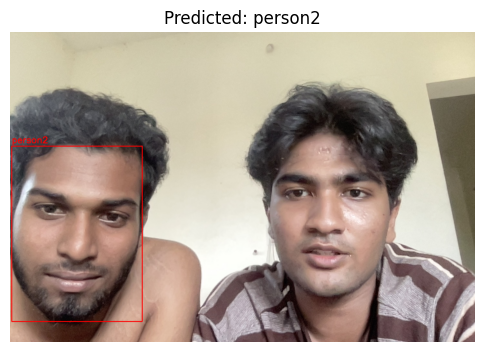

In [ ]:
# 🔍 Step 9: Predict and draw a bounding box around the face
import matplotlib.pyplot as plt

def predict_face(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = app.get(img_rgb)

    if len(faces) == 0:
        print("No face detected.")
        return

    face = faces[0]
    test_embedding = face.embedding
    pred = knn.predict([test_embedding])
    pred_label = le.inverse_transform(pred)[0]
    print(f"Prediction: {pred_label}")

    # Draw bounding box
    box = face.bbox.astype(int)
    x1, y1, x2, y2 = box
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red box
    cv2.putText(img_rgb, pred_label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Show the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}")
    plt.show()

predict_face(test_image_path)


Detected: person1 at [40, 24, 82, 82]


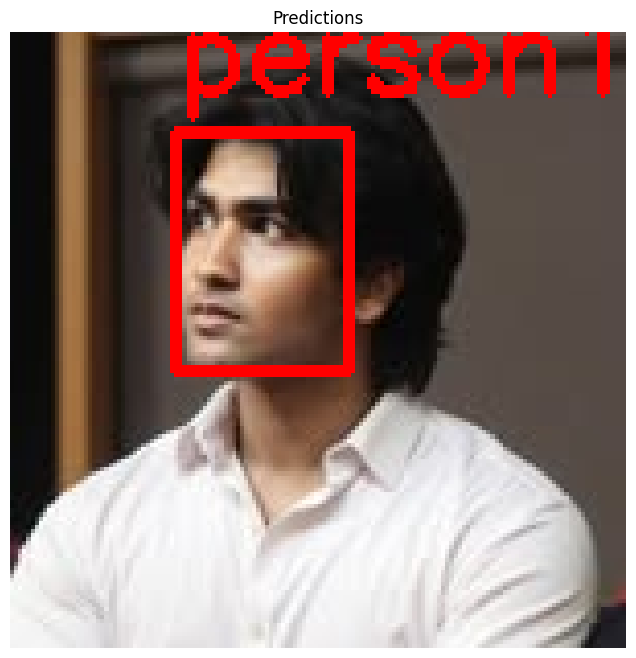

In [ ]:
# 🔍 Step 9: Predict and draw bounding boxes for all detected faces
import matplotlib.pyplot as plt

def predict_faces(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = app.get(img_rgb)

    if len(faces) == 0:
        print("No faces detected.")
        return

    for face in faces:
        embedding = face.embedding
        pred = knn.predict([embedding])
        pred_label = le.inverse_transform(pred)[0]

        # Draw bounding box
        x1, y1, x2, y2 = face.bbox.astype(int)
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_rgb, pred_label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        print(f"Detected: {pred_label} at [{x1}, {y1}, {x2}, {y2}]")

    # Show the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Predictions")
    plt.show()

predict_faces(test_image_path)


## Video functionality

In [ ]:
print("Upload a video to verify a person (e.g., person1)")
video_upload = files.upload()
video_path = list(video_upload.keys())[0]

Upload a video to verify a person (e.g., person1)


Saving Movie on 24-04-25 at 9.00 PM #2.mov to Movie on 24-04-25 at 9.00 PM #2.mov


In [ ]:
import cv2
import random

def sample_frames(video_path, num_segments=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    segment_size = frame_count // num_segments
    sampled_frames = []

    for i in range(num_segments):
        start = i * segment_size
        end = (i + 1) * segment_size
        if start >= end:
            continue
        random_frame = random.randint(start, end - 1)
        cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
        ret, frame = cap.read()
        if ret:
            sampled_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    return sampled_frames

In [ ]:
import matplotlib.pyplot as plt

def verify_person_in_video(video_path, target_label='person1', threshold=3):
    frames = sample_frames(video_path)
    correct_matches = 0
    matched_frames = []

    for idx, frame in enumerate(frames):
        faces = app.get(frame)
        if not faces:
            print(f"No face in frame {idx+1}")
            continue

        face = faces[0]
        pred = knn.predict([face.embedding])
        pred_label = le.inverse_transform(pred)[0]
        print(f"Frame {idx+1}: Predicted {pred_label}")

        # Draw red bounding box
        x1, y1, x2, y2 = face.bbox.astype(int)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, pred_label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        # Save frame if it matched
        if pred_label == target_label:
            correct_matches += 1
            matched_frames.append((idx + 1, frame))

    print(f"\n✔️ {correct_matches}/5 frames matched '{target_label}'")
    if correct_matches >= threshold:
        print(f"✅ Person '{target_label}' verified in video.")
    else:
        print(f"❌ Person '{target_label}' not verified.")

    # Show matched frames
    for i, frame in matched_frames:
        plt.figure(figsize=(6, 6))
        plt.imshow(frame)
        plt.title(f"Matched Frame {i}")
        plt.axis("off")
        plt.show()


Frame 1: Predicted person1
Frame 2: Predicted person1
Frame 3: Predicted person1
Frame 4: Predicted person1
Frame 5: Predicted person1

✔️ 5/5 frames matched 'person1'
✅ Person 'person1' verified in video.


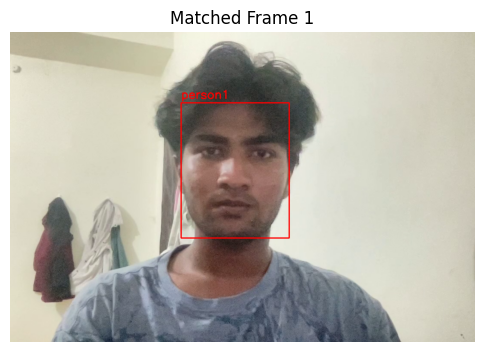

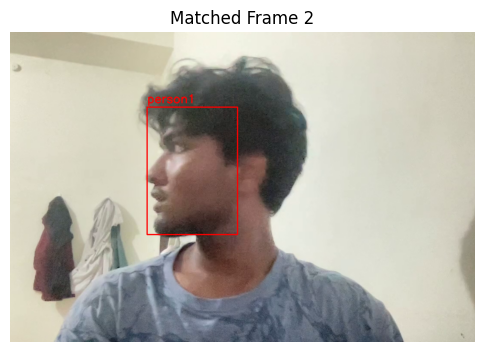

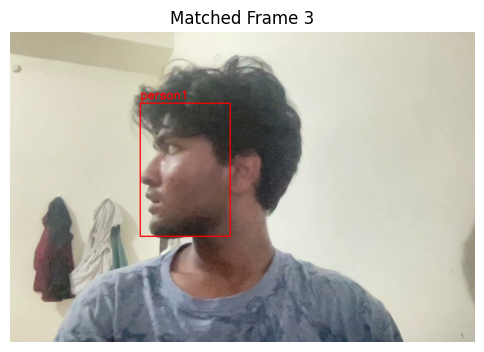

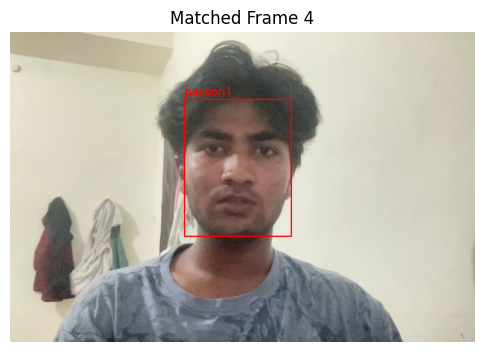

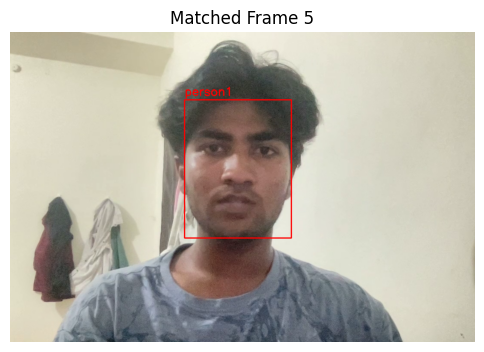

In [ ]:
verify_person_in_video(video_path, target_label='person1')

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
import pickle

def extract_zip(zip_path, extract_to='person_images'):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

def preprocess_and_extract_features(image_folder, output_path='features_labels.pkl'):
    app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(640, 640))

    features = []
    labels = []

    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = app.get(img_rgb)
        if faces:
            features.append(faces[0].embedding)
            labels.append("person-test")

    features = np.array(features)
    labels = np.array(labels)

    with open(output_path, 'wb') as f:
        pickle.dump((features, labels), f)

    print(f"Saved features and labels to: {output_path}")
    return output_path


In [ ]:
import cv2
import numpy as np
import pickle
import os
import random
import insightface
from insightface.app import FaceAnalysis
from sklearn.neighbors import KNeighborsClassifier

def sample_frames(video_path, num_segments=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    segment_size = frame_count // num_segments
    frames = []

    for i in range(num_segments):
        start = i * segment_size
        end = (i + 1) * segment_size
        if start >= end:
            continue
        cap.set(cv2.CAP_PROP_POS_FRAMES, random.randint(start, end - 1))
        ret, frame = cap.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    return frames

def verify_person_in_video(video_path, features_labels_path, threshold=3):
    with open(features_labels_path, 'rb') as f:
        features, labels = pickle.load(f)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(features, labels)

    app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(640, 640))

    frames = sample_frames(video_path)
    match_count = 0

    for idx, frame in enumerate(frames):
        faces = app.get(frame)
        if not faces:
            continue
        pred = knn.predict([faces[0].embedding])[0]
        if pred == 'person-test':
            match_count += 1

    print(f"{match_count}/5 frames matched")
    return match_count >= threshold
